In [ ]:
# !pip install torchgeo lightly!=1.4.26
# !pip install pycocotools

In [3]:
import os
import json
import glob
import torch

import cv2
import base64
import numpy as np
import pandas as pd
import io
import PIL

from tqdm import tqdm
from PIL import Image
import matplotlib.pyplot as plt
import albumentations as A

from torch.utils.data import Dataset,DataLoader
from torchvision.utils import draw_bounding_boxes
from torchgeo.trainers import ObjectDetectionTask
from torchgeo.models import ResNet50_Weights
import lightning.pytorch as pl

import warnings
warnings.filterwarnings("ignore")

C:\Users\surya\AppData\Local\Programs\Python\Python310\lib\site-packages\requests\__init__.py:102: RequestsDependencyWarning: urllib3 (1.26.14) or chardet (5.0.0)/charset_normalizer (2.0.8) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({})/charset_normalizer ({}) doesn't match a supported "


In [4]:
class MaskGenerator:
    def __init__(self,save_path):
        self.root = "data/train"
        
        self.post_img,self.post_label = self.loadPath('post')
#         self.pre_img,self.pre_label = self.loadPath('pre')
        
        assert len(self.post_img) == len(self.post_label)
#         assert len(self.pre_img) == len(self.pre_label)
        
        self.mask_path = os.path.join("data",save_path)
        os.makedirs(self.mask_path,exist_ok=True)
        os.makedirs(os.path.join(self.mask_path,'pre'),exist_ok=True)
        os.makedirs(os.path.join(self.mask_path,'post'),exist_ok=True)
        
    
    def loadPath(self,mode):

        if mode=="pre":
            pre_dis_imgs = glob.glob(f"{self.root}/post/img/*")
            pre_dis_labels = glob.glob(f"{self.root}/post/label/*")
            return pre_dis_imgs,pre_dis_labels
        else:  
            post_dis_imgs = glob.glob(f"{self.root}/post/img/*")
            post_dis_labels = glob.glob(f"{self.root}/post/label/*")
            return post_dis_imgs,post_dis_labels
    
    def img_b64_to_arr(self,img_b64):
        
        img_data = base64.b64decode(img_b64)
        
        file = io.BytesIO()
        file.write(img_data)
        
        img_pil = PIL.Image.open(file)
        img_arr = np.array(img_pil)
        
        return img_arr
    
    def convertLabel(self,label_file,mode):
        
        fname = os.path.basename(label_file).replace(".json",".png")
        
        with open(label_file,'r') as f:
            data = json.load(f)
    
        image_width = data["imageWidth"]
        image_height = data["imageHeight"]

        masks = np.zeros((image_width,image_height),dtype = np.int8)
        
        for shape in data["shapes"]:
        
            building_mask = self.img_b64_to_arr(shape['mask'])
            offset_x , offset_y = int(shape['points'][0][0]),int(shape['points'][0][1])
            masks[offset_y:offset_y+building_mask.shape[0],offset_x:offset_x+building_mask.shape[1]] = building_mask
        
        if mode=="pre":
            plt.imsave(os.path.join(os.path.join(self.mask_path,'pre'),fname),masks,cmap="gray")
        else:
            plt.imsave(os.path.join(os.path.join(self.mask_path,'post'),fname),masks,cmap="gray")
             
    
    def run(self,mode):
        if(mode=="pre"):
            print("Generating masks for pre disaster images:")
            for json_file in tqdm(self.pre_label,total = len(self.post_label)):
                self.convertLabel(json_file,mode)
        else:
            print("Generating masks for post disaster images:")
            for json_file in tqdm(self.post_label,total = len(self.post_label)):
                self.convertLabel(json_file,mode)

In [5]:
generate_masks = MaskGenerator('masks')

In [6]:
generate_masks.run('post')

Generating masks for post disaster images:


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:03<00:00, 36.50it/s]


In [7]:
class FileInformation:
    def __init__(self,fname_csv):
        self.root = "data/train"
        
        self.post_img,self.post_label = self.loadPath('post')      
        self.fname = fname_csv
        assert len(self.post_img) == len(self.post_label)
    
    def loadPath(self,mode):
        if mode=="pre":
            pre_dis_imgs = glob.glob(f"{self.root}/post/img/*")
            pre_dis_labels = glob.glob(f"{self.root}/post/label/*")
            return pre_dis_imgs,pre_dis_labels
        else:  
            post_dis_imgs = glob.glob(f"{self.root}/post/img/*")
            post_dis_labels = glob.glob(f"{self.root}/post/label/*")
            return post_dis_imgs,post_dis_labels
    
    def metadata(self,label_file):
        
        tile = os.path.basename(label_file).replace('.json',"")
        img_fpath = os.path.join(os.path.join('post','img'),tile+'.jpg')
        label_fpath = os.path.join(os.path.join('post','label'),tile+'.json')
        
        with open(label_file,'r') as f:
            json_data = json.load(f)
        
        l = []
        for shape in json_data["shapes"]:
            
            class_name = shape['label'] 
            x1,y1,x2,y2 = shape['points'][0][0],shape['points'][0][1],shape['points'][1][0],shape['points'][1][1]
#             x2 = x2 - x1
#             y2 = y2 - y1
            d = {
                    'tile_X_Y':tile,'image_fname':img_fpath,'label_fname':label_fpath,\
                    'class_name':class_name,'xabs':x1,'yabs':y1,'width':x2,'height':y2\
                }
            l.append(d)
        return l
    
    def run(self):
        
        blob = []
        print("Generating metadata csv:")
        for json_file in tqdm(self.post_label,total = len(self.post_label)):
            blob.extend(self.metadata(json_file))
        csv_meta = pd.DataFrame(blob)
        csv_meta.to_csv(self.fname,index=False)
        

In [8]:
generate_metadata = FileInformation('metadata.csv')

In [9]:
generate_metadata.run()

Generating metadata csv:


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:00<00:00, 5342.44it/s]


In [10]:
class plotImage:
    
    def __init__(self):
        
        self.root = 'data/train'
        metadata = pd.read_csv('metadata.csv')
        random_tile = metadata.sample(n=1)
        self.img_path = os.path.normpath(os.path.join(self.root,str(random_tile.values[0][1])))
        self.mask_path = os.path.normpath(os.path.join('data/masks/post',str(random_tile.values[0][0])+'.png'))
        self.plot()
        
    def read_image(self,path):
        '''
        Reads the image using CV library

        '''
        img =  cv2.imread(path)
        if img is None:
            raise FileNotFoundError(path)
        return img

    def overlay_mask(self,image,mask):
        '''
        Overlays the mask over the original image
        '''
        overlay_image = cv2.cvtColor(image.copy(),cv2.COLOR_BGR2RGB)
        
        overlay_image[mask==255] = (255,12,12)
        return cv2.addWeighted(overlay_image,0.5,image,0.4,0)

    def load_mask(self,path):
        '''
        Loads the image mask

        '''
        mask =  cv2.imread(path,cv2.IMREAD_GRAYSCALE)
        return mask
    
    def plot(self):
        fig,ax = plt.subplots(1,3,figsize=(30,9))
        
        ax[0].imshow(cv2.cvtColor(self.read_image(self.img_path).astype(np.uint8), cv2.COLOR_BGR2RGB))
        ax[0].axis('off')
        ax[0].set_title('Aerial Satellite Image')
        ax[1].imshow(self.read_image(self.mask_path))
        ax[1].axis('off')
        ax[1].set_title('Image Mask')
        ax[2].imshow(self.overlay_mask(self.read_image(self.img_path),self.load_mask(self.mask_path)))
        ax[2].axis('off')
        ax[2].set_title('Mask Overlayed on Image')

        plt.show()
    


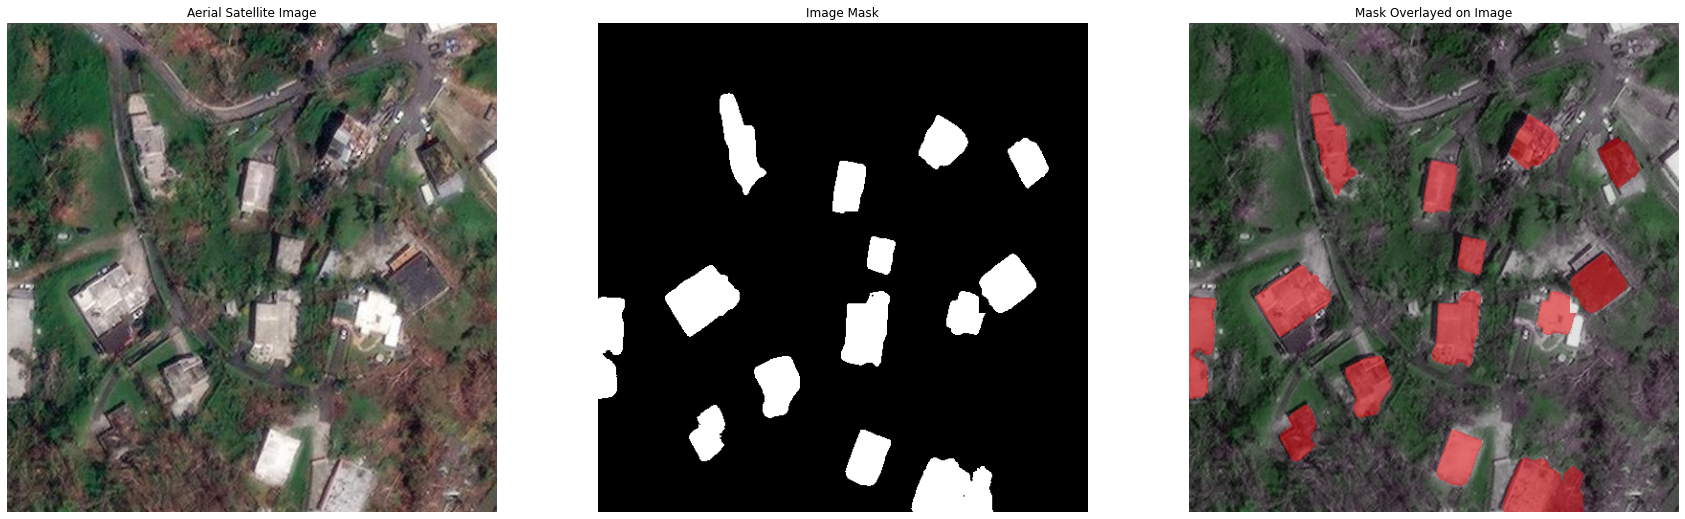

In [13]:
plot = plotImage()

In [2]:
class ImageDataset(Dataset):
    
    def __init__(self,transform):
        self.root = 'data/train'
        
        self.post_imglist,self.post_labellist = self.loadPath('post')
        #self.pre_img,self.pre_label = self.loadPath('pre')
        assert len(self.post_imglist) == len(self.post_labellist)
        #assert len(self.pre_img) == len(self.pre_label)
        
        self.mask_filenames = glob.glob(f"data/masks/post/*")
        self.metadata = pd.read_csv('metadata.csv')
        self.transform = transform
    
    def __len__(self):
        return len(self.post_imglist)
    
    def __getitem__(self,index):
        
        tile_name = os.path.basename(self.post_imglist[index]).replace('.jpg',"")
        tile_data = self.metadata[self.metadata['tile_X_Y']==tile_name]
        bboxes = np.array(tile_data.iloc[:,-4:])
        
        class_names = {'undamagedresidentialbuilding':'0',
                       'damagedresidentialbuilding':'1',
                       'undamagedcommercialbuilding':'2',
                       'damagedcommercialbuilding':'3'}
        
        func = lambda x : x.replace(x,class_names[x])
        class_labels =[eval(func(i)) for i in (np.array(tile_data.class_name))]
        
        image = self.read_image(self.post_imglist[index])
        aug = self.transform(image = image,bboxes =bboxes ,class_labels = class_labels)
        l = torch.tensor(aug['class_labels'])
        bbox = torch.tensor(aug['bboxes'])
        
        
        post_image = torch.tensor(aug['image'],dtype = torch.float32)
        post_image = post_image.view(post_image.shape[2], post_image.shape[0],post_image.shape[1])
        mask_image = torch.tensor(self.load_mask(self.mask_filenames[index]))
        
        
        d = {'image':post_image,'labels':l,'boxes':bbox,'masks':mask_image}
        return d
       
    def loadPath(self,mode):
        if mode=="pre":
            pre_dis_imgs = glob.glob(f"{self.root}/post/img/*")
            pre_dis_labels = glob.glob(f"{self.root}/post/label/*")
            return pre_dis_imgs,pre_dis_labels
        else:  
            post_dis_imgs = glob.glob(f"{self.root}/post/img/*")
            post_dis_labels = glob.glob(f"{self.root}/post/label/*")
            return post_dis_imgs,post_dis_labels
    
    def load_mask(self,path):
        mask =  cv2.imread(path,cv2.IMREAD_GRAYSCALE)
        return mask
    
    def read_image(self,path):
        img =  cv2.imread(path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        if img is None:
            raise FileNotFoundError(path)
        return img


In [10]:
alb = A.Compose([
    A.RandomRotate90(p=1),
    A.Transpose(p=0.5),
    A.RandomGamma(gamma_limit=(90, 110)),
    A.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3, p=1),
],bbox_params= A.BboxParams(format = "pascal_voc",label_fields=['class_labels']))

dataset = ImageDataset(
    transform = alb 
)

In [11]:
def collate_fn(batch):
    new_batch = {
        "image": [torch.tensor(item["image"]).to('cuda') for item in batch],
        "boxes": [torch.tensor(item["boxes"]).to('cuda') for item in batch],
        "labels": [torch.tensor(item["labels"]).to('cuda') for item in batch],
        "masks": [torch.tensor(item["masks"]).to('cuda') for item in batch],
    }
    return new_batch

dl = DataLoader(dataset,batch_size=5,shuffle=True,collate_fn=collate_fn)

In [12]:
class VariableSizeInputObjectDetectionTask(ObjectDetectionTask):
    def training_step(self, batch, batch_idx, dataloader_idx=0):
        x = batch["image"]
        batch_size = len(x)  # we change this line to support variable size inputs
        y = [
            {"boxes": batch["boxes"][i], "labels": batch["labels"][i]}
            for i in range(batch_size)
        ]
        loss_dict = self(x, y)
        train_loss: Tensor = sum(loss_dict.values())
        self.log_dict(loss_dict)
        return train_loss
    
    def test_step(self, batch, batch_idx, dataloader_idx = 0):
        x = batch["image"]
        batch_size = len(x)
        y = [
            {"boxes": batch["boxes"][i], "labels": batch["labels"][i]}
            for i in range(batch_size)
        ]
        y_hat = self(x)
        metrics = self.test_metrics(y_hat, y)

        metrics.pop("test_classes", None)

        self.log_dict(metrics)
#     def configure_metrics(self):
#         metrics = MetricCollection([MeanAveragePrecision(average="micro")])
#         self.val_metrics = metrics.clone(prefix="val_")
#         self.test_metrics = metrics.clone(prefix="test_")

In [13]:
weights = ResNet50_Weights.SENTINEL2_RGB_MOCO
# weights.meta

In [14]:
task = VariableSizeInputObjectDetectionTask(
    model="retinanet",
    backbone="resnet50",
    weights=weights,
    in_channels=3,
    num_classes=4,
    trainable_layers=4,
    lr=0.1,
    patience=5,
    freeze_backbone=False,
)

task.monitor = "classification"

In [15]:
trainer = pl.Trainer(
    default_root_dir="logs/",
    accelerator="gpu",
    min_epochs=1,
    max_epochs=5,
#     log_every_n_steps=100,
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [16]:
def draw_bbox(image, annotations):
        new_image = image.copy()
        for annotation in annotations:
            x1, y1, x2, y2 = annotation
             
            cv2.rectangle(new_image, (x1, y1), (x2, y2), (0, 255, 0), 2)
        return new_image

def visualizeResults(image,annotation):
    res_image = draw_bbox(image,annotation)
    plt.figure(figsize=(10,15))
    plt.imshow(res_image)
    plt.axis('off')
    plt.show()

In [17]:
batch = next(iter(dl))

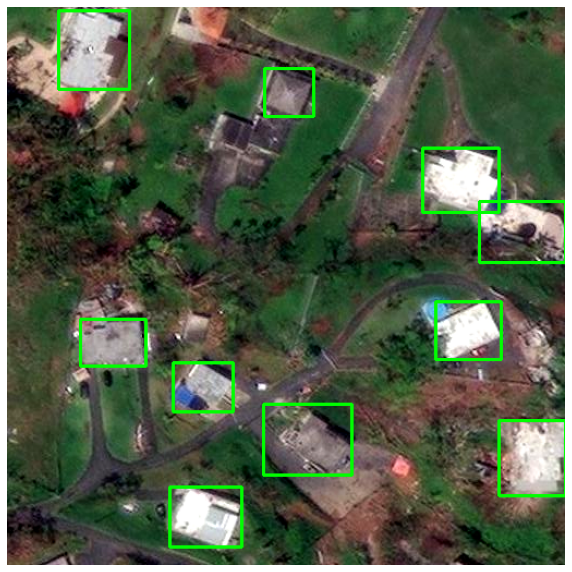

In [21]:
index = 4
img = batch['image'][index].type(torch.uint8).cpu().numpy()
res_image =  img.reshape(img.shape[1],img.shape[2],img.shape[0])

box = batch['boxes']
bbox = box[index].type(torch.int64).cpu().numpy()

visualizeResults(res_image,bbox)

In [ ]:
# Lightning fitS()
trainer.fit(task, train_dataloaders=dl)

In [ ]:
# Lightning test()
trainer.test(task,dl)

In [ ]:
# Lightning predict()
out = trainer.predict(task,dataloaders=dl)

In [ ]:
batch = next(iter(dl))
batch["image"] = [image.to("cuda:0") for image in batch["image"]]

In [ ]:
model = trainer.model
model.eval()
model.to('cuda')
with torch.inference_mode():
    out = model(batch['image'])

In [ ]:
INDEX = 0
img_out = batch['image'][INDEX].type(torch.uint8).cpu().numpy()
res_image =  img_out.reshape(img_out.shape[1],img_out.shape[2],img_out.shape[0])

box = out[INDEX]['boxes']
bbox = box.type(torch.int64).cpu().numpy()
visualizeResults(res_image,bbox)

In [ ]:
out